# Классификация, детекция.

## Часть 1. Классификация

План:
* Написать класс датасета
* Написать функции обучения и оценки модели
* Сделать тюнинг resnet модели для классификации изображений
* Обучить и оценить

Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).
В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199.

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -q '/content/drive/MyDrive/Colab_Notebooks/dataset.zip'

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
# You may add any imports you need a

import os
from os.path import isfile, join

import pandas as pd
import matplotlib.pyplot as plt
import sys

import torch
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize, ToTensor, Compose

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models
!pip install colour
from colour import Color

from tqdm import tqdm

from PIL import Image
#!pip install cv2
#import cv2

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = os.path.expanduser(data_dir)
        self.transform = transform

        def load_images(path):
            """
            returns all the sorted image paths.

            :param path:
            :return: лист с путями до всех изображений
            """
            images_dir = []
            for class_ in os.listdir(path):
                images_dir += [[join(path, class_, f), int(class_[-3:])] for f in os.listdir(join(path, class_))
                            if isfile(join(path, class_, f))]

            return images_dir

        self.data_path = load_images(self.data_dir)

    def __getitem__(self, index):
        """

        :param index:
        :return: tuple (img, target) with the input data and its label
        """

        img = Image.open(self.data_path[index][0]).convert("RGB")
        target = self.data_path[index][1]
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.data_path)


In [ ]:
train_transform = transforms.Compose([Resize((224,224)), ToTensor(), Normalize((0.5, 0.5, 0.5), (1, 1, 1)), ])
val_transform = transforms.Compose([Resize((224, 224)), ToTensor(), Normalize((0.5, 0.5, 0.5), (1, 1, 1)), ])

train_dataset = MyDataset("dataset/dataset/train", transform=train_transform)
val_dataset = MyDataset("dataset/dataset/val", transform=val_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=0)#, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=0)#, collate_fn=collate_fn)

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
            
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    
    return metrics

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.eval()
    losses = np.array([])
    predicted_classes = np.array([])
    true_classes = np.array([])
    with tqdm(total=len(val_dataloader), file=sys.stdout) as prbar:
        for images, labels in val_dataloader:
            images = images.to(device=device)
            labels = labels.to(device=device)
            
            predicted = model(images)
            
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            
            losses = np.append(losses, loss.item())
            predicted_classes = np.append(predicted_classes, predicted.argmax(1).cpu().detach().numpy())
            true_classes = np.append(true_classes, labels.cpu().detach().numpy())
            
    return losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(n_epochs):
        # Train, evaluate, print accuracy, make a step of scheduler or whatever you want...
        print(f"Train Epoch: {epoch}")
        train_metrics = train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer
        )
        # Save Train losses
        epoch_train_losses.append(train_metrics['loss'])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            losses, predicted_classes, true_classes = predict(
                model=model,
                val_dataloader=val_dataloader,
                criterion=criterion
            )
        val_loss = losses.mean()
        scheduler.step(val_loss)
        # Save eval losses
        #epoch_eval_losses.append(validation_metrics['loss'])

In [ ]:
from torchvision.models import resnet18
torch.cuda._initialized = True

model = resnet18(pretrained=True)#.to(device)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512, 200)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4)

In [ ]:
model = model
optimizer = optimizer
train_dataloader = train_loader
val_dataloader = val_loader
criterion = criterion
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, verbose=True)
n_epochs = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Запустить обучение можно в ячейке ниже.

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train Epoch: 0
Loss: 3.012 Accuracy: 35.0: 100%|██████████| 5000/5000 [05:51<00:00, 14.21it/s]
Validation Epoch: 0
Loss: 2.7844 Accuracy: 40.0: 100%|██████████| 1000/1000 [00:36<00:00, 27.12it/s]
Train Epoch: 1
Loss: 1.9218 Accuracy: 55.0: 100%|██████████| 5000/5000 [05:50<00:00, 14.26it/s]
Validation Epoch: 1
Loss: 2.1647 Accuracy: 60.0: 100%|██████████| 1000/1000 [00:37<00:00, 26.89it/s]
Train Epoch: 2
Loss: 1.6617 Accuracy: 60.0: 100%|██████████| 5000/5000 [05:48<00:00, 14.35it/s]
Validation Epoch: 2
Loss: 2.6118 Accuracy: 40.0: 100%|██████████| 1000/1000 [00:35<00:00, 28.42it/s]
Train Epoch: 3
Loss: 2.1207 Accuracy: 50.0: 100%|██████████| 5000/5000 [05:39<00:00, 14.71it/s]
Validation Epoch: 3
Loss: 2.6986 Accuracy: 40.0: 100%|██████████| 1000/1000 [00:35<00:00, 28.27it/s]
Train Epoch: 4
Loss: 1.731 Accuracy: 55.0: 100%|██████████| 5000/5000 [05:41<00:00, 14.63it/s]
Validation Epoch: 4
Loss: 1.9935 Accuracy: 40.0: 100%|██████████| 1000/1000 [00:35<00:00, 28.13it/s]
Train Epoch: 5
Lo

Простой тест на проверку правильности написанного кода и оценка точности модели.

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Loss: 1.368 Accuracy: 70.0: 100%|██████████| 1000/1000 [00:37<00:00, 26.50it/s]
tests passed


## Часть 2. Object detection.

Детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [2]:
# we will need this library to process the labeling
! pip install xmltodict

In [3]:
import xmltodict, json

In [4]:
#! unzip -q '/content/drive/MyDrive/Colab_Notebooks/archive.zip'

Класс датасета

In [5]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
# add any imports you need
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from PIL import Image
from tqdm import tqdm


class2tag = {"apple": 0, "orange": 1, "banana": 2}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(Image.open(image_fname).convert("RGB"))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform is not None:
            return self.transform(self.images[i]), self.annotations[i]
        else:
            return self.images[i], self.annotations[i]
        '''
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]
        '''

    def __len__(self):
        return len(self.images)

UoL и функции оценки модели:

In [6]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

План:
 - Создать модель и оптимайзер
 - Написать функцию обучения модели
 - Использовать аугментации
 - Обучить модель для object detection

In [7]:
def train_one_epoch(model, optimizer, train_dataloader, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    #return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        a = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: {0}".format(a))
        train_one_epoch(model, optimizer, train_dataloader, device=device)

In [8]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
torch.cuda._initialized = True

def get_detection_model(num_classes=2):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [9]:
def get_transform(train=False):
    transforms = []
    if train:
        transforms.append(T.RandomGrayscale(p=0.1))
        #transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToTensor())
    #transforms.append(T.Normalize((0.5, 0.5, 0.5), (1, 1, 1)))
    return T.Compose(transforms)

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [11]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#print(torch.device('cuda'))
#print(device)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
num_classes = 3

train_dataset = FruitDataset("./train_zip/train", get_transform(train=True))
val_dataset = FruitDataset("./test_zip/test", get_transform(train=True))


train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

model = get_detection_model(num_classes).to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)# SELECT YOUR OPTIMIZER

n_epochs = 10 # SELECT APPROPRIZTE NUMBER OF EPOCHS
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


AUC ON TEST: 0.0003270869199961134
Loss value after 10 batches is 0.44
Loss value after 20 batches is 0.37
Loss value after 30 batches is 0.31
Loss value after 40 batches is 0.3
Loss value after 50 batches is 0.27
Loss value after 60 batches is 0.26
AUC ON TEST: 0.5728626163872361
Loss value after 10 batches is 0.17
Loss value after 20 batches is 0.19
Loss value after 30 batches is 0.17
Loss value after 40 batches is 0.16
Loss value after 50 batches is 0.15
Loss value after 60 batches is 0.15
AUC ON TEST: 0.6129470948029169
Loss value after 10 batches is 0.12
Loss value after 20 batches is 0.1
Loss value after 30 batches is 0.11
Loss value after 40 batches is 0.11
Loss value after 50 batches is 0.11
Loss value after 60 batches is 0.11
AUC ON TEST: 0.6538793422154118
Loss value after 10 batches is 0.11
Loss value after 20 batches is 0.11
Loss value after 30 batches is 0.1
Loss value after 40 batches is 0.11
Loss value after 50 batches is 0.11
Loss value after 60 batches is 0.1
AUC ON TE

__Итоговое качество модели__.

In [13]:
auc = evaluate(model, val_dataloader, device)
print("Точность: {}".format(auc))

0.6446534030334987


Предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [52]:
image, labels = train_dataset[0]
pred = model(image.unsqueeze(0).to(device))[0]

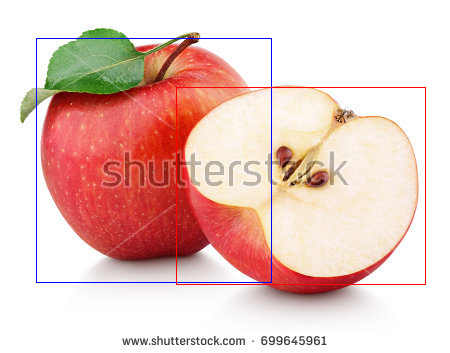

In [53]:
from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

In [49]:
image, labels = train_dataset[2]
pred = model(image.unsqueeze(0).to(device))[0]

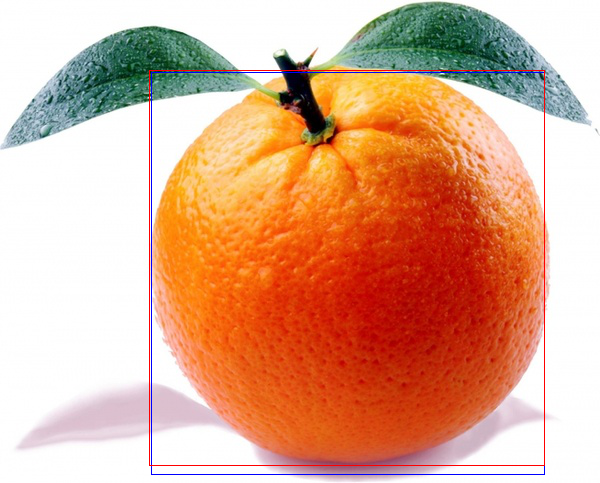

In [50]:
from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

# **Вывод:**

1.   В первом номере использовал transfer learning с использованием pre-trained resnet18, заменил последний слой на полносвязный слой с 200 выходами. Для данного датасета добился весьма неплохого качества с точностью 0.8.
Расписание для learning rate не дало значительного прироста в качестве модели.
2.   Во втором номере пробовал увелить AUC аугментациями и методами оптимизации. Адам плохо сходился, градиентный спуск с данными параметрами показал наилучший результат. Текущие настройки аугментаций также дали наилучший результат. Рандомный переворот фото ухудшает качество модели на всех возможных выборках. Нормализация не сильно, но тоже ухудшала качество модели.

